# Spark

## Initialisation Spark et chargement des données

In [46]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [48]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import col, isnan, when, count, sum, monotonically_increasing_id, row_number
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType, StringType
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# Initialisation de SparkSession
spark = SparkSession.builder \
    .appName("MovieRatingPrediction") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .config("spark.driver.host", "127.0.0.1") \
    .getOrCreate()

ConnectionRefusedError: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée

In [6]:
# Définition des noms de colonnes
schema = StructType([
    StructField("Cust_Id", StringType(), True),
    StructField("Rating", FloatType(), True),
    StructField("Unused", StringType(), True)
])

In [7]:
# Lecture des fichiers CSV
df1 = spark.read.csv('input/combined_data_1.txt', header=False, schema=schema).select("Cust_Id", "Rating")
df2 = spark.read.csv('input/combined_data_2.txt', header=False, schema=schema).select("Cust_Id", "Rating")
df3 = spark.read.csv('input/combined_data_3.txt', header=False, schema=schema).select("Cust_Id", "Rating")
df4 = spark.read.csv('input/combined_data_4.txt', header=False, schema=schema).select("Cust_Id", "Rating")

## Formatage des données

In [11]:
# Union des DataFrames
df_combined = df1.union(df2).union(df3).union(df4)

In [12]:
df_combined.show(3)

+-------+------+
|Cust_Id|Rating|
+-------+------+
|     1:|  NULL|
|1488844|   3.0|
| 822109|   5.0|
+-------+------+
only showing top 3 rows



In [13]:
df_combined = df_combined.withColumn("is_movie_delimiter", df_combined["Rating"].isNull())

In [15]:
# Ajouter un identifiant unique à chaque ligne
df_combined = df_combined.withColumn("RowId", monotonically_increasing_id())

In [17]:
window_spec = Window.orderBy("RowId")

In [18]:
# Marquer les délimitations de film avec 1 et les autres avec 0
df_combined = df_combined.withColumn("Movie_Increment", when(col("is_movie_delimiter"), 1).otherwise(0))

In [19]:
df_combined.show(3)

+-------+------+------------------+-----+---------------+
|Cust_Id|Rating|is_movie_delimiter|RowId|Movie_Increment|
+-------+------+------------------+-----+---------------+
|     1:|  NULL|              true|    0|              1|
|1488844|   3.0|             false|    1|              0|
| 822109|   5.0|             false|    2|              0|
+-------+------+------------------+-----+---------------+
only showing top 3 rows



In [20]:
# Calculer le Movie_Id en utilisant la somme cumulative
df_combined = df_combined.withColumn("Movie_Id", sum("Movie_Increment").over(window_spec))

In [21]:
# Filtrer les délimitations de film et sélectionner les colonnes nécessaires
df_combined = df_combined.filter(~col("is_movie_delimiter")) \
                         .select("Cust_Id", "Rating", "Movie_Id")

In [22]:
df_combined.show(3)

+-------+------+--------+
|Cust_Id|Rating|Movie_Id|
+-------+------+--------+
|1488844|   3.0|       1|
| 822109|   5.0|       1|
| 885013|   4.0|       1|
+-------+------+--------+
only showing top 3 rows



In [23]:
df_combined.count()

100480507

In [24]:
df_combined.printSchema()

root
 |-- Cust_Id: string (nullable = true)
 |-- Rating: float (nullable = true)
 |-- Movie_Id: long (nullable = true)



In [25]:
df_combined.select('Movie_Id').distinct().count()

17770

## Exploration

In [28]:
# Distribution des notes
rating_counts = df_combined.groupBy("Rating").count().orderBy("Rating")
rating_counts_df = rating_counts.toPandas()
total_count = rating_counts_df['count'].sum()
rating_counts_df['Percentage'] = (rating_counts_df['count'] / total_count) * 100

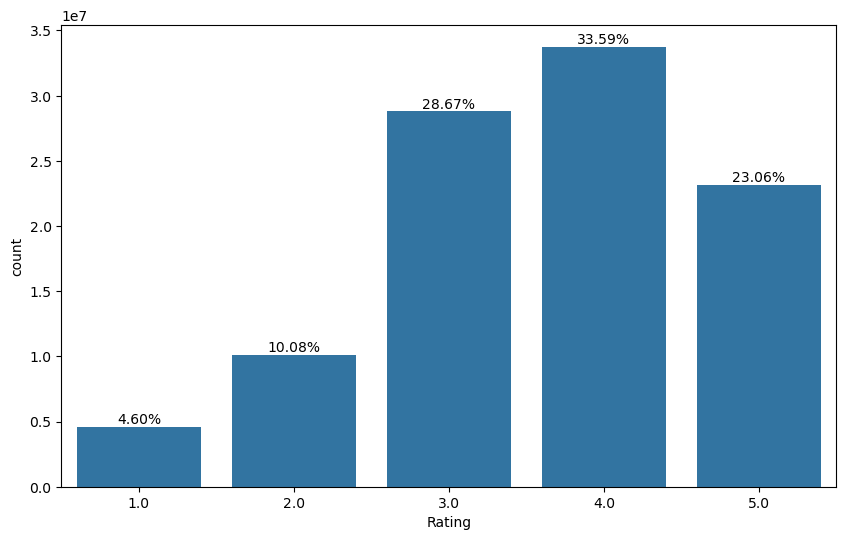

In [29]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=rating_counts_df, x='Rating', y='count')
for index, row in rating_counts_df.iterrows():
    bar = barplot.patches[index]
    barplot.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f"{row['Percentage']:.2f}%",
                 color='black',
                 ha="center",
                 va="bottom")
plt.show()

## Preparation pour le Modele

In [34]:
# Conversion de Cust_Id en catégorie
indexer = StringIndexer(inputCol="Cust_Id", outputCol="Cust_Id_Indexed")
df_combined = indexer.fit(df_combined).transform(df_combined)

In [36]:
# Assemblage des caractéristiques
assembler = VectorAssembler(inputCols=["Cust_Id_Indexed", "Movie_Id"], outputCol="features")
df_combined = assembler.transform(df_combined)

In [ ]:
# Normalisation des caractéristiques
#scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
#scaler_model = scaler.fit(df_combined)
#df_combined = scaler_model.transform(df_combined)

In [38]:
# Séparation des données en ensembles d'entraînement et de test (echantillonage test)
(train_data, test_data) = df_combined.randomSplit([0.9, 0.1], seed=42)

## construction du modele KNN

In [40]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col

In [42]:
# Modèle de KNN basé sur ALS pour obtenir les similarités
als = ALS(userCol="Cust_Id_Indexed", itemCol="Movie_Id", ratingCol="Rating", 
          nonnegative=True, implicitPrefs=False, coldStartStrategy="drop")
model = als.fit(train_data)

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "C:\Users\melan\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\melan\AppData\Local\Temp\ipykernel_15724\854353161.py", line 4, in <module>
    model = als.fit(train_data)
            ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\melan\anaconda3\Lib\site-packages\pyspark\ml\base.py", line 205, in fit
    return self._fit(dataset)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\melan\anaconda3\Lib\site-packages\pyspark\ml\wrapper.py", line 381, in _fit
    java_model = self._fit_java(dataset)
                 ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\melan\anaconda3\Lib\site-packages\pyspark\ml\wrapper.py", line 378, in _fit_java
    return self._java_obj.fit(dataset._jdf)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\melan\anaconda3\Lib\site-packages\py4j\java_gateway.py", line 1322, in __c

ConnectionRefusedError: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée

In [44]:
pyspark

NameError: name 'pyspark' is not defined

In [ ]:
# Transformation des données pour obtenir les prédictions
predictions = model.transform(test_data)

In [ ]:
# Évaluation du modèle
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")